# How good are stocks?

The goal of this notebook is to find out if it's worth it to invest in stocks, and how much you're likely to earn. In this notebook, I'm not interested in a specific stock (say Microsoft or Walmart), but instead in the average performance of all stocks.

In other words, imagine I buy 100$ worth of the top 500 companies (these companies are commonly called the S&P500, or Standard and Poor's 500). Here are some questions I'd like to explore: 

- How much will I have in 5, 10, 20, 40 years? 
- Does the time of the purchase matter? Is buying too soon or too late a problem, or is it something I don't need to care about?
- What is the variability? Are returns very volatile, or generally stable?
- How long do I have to wait to have a 90% chance of making money overall? 

## Our approach

To figure this out, we could make a complicated model of the stock market and the world economy, with tons of variables and complicated equations. However, I don't have the time, nor the interest. Instead, I'll simply look at the past and see how much money I would have made if I had bought stocks.

**Example**: If I had bought 1000$ worth of S&P500 in March 1998, how much would these shares be worth in 1999? In 2000? In 2005? In 2010? In 2018?

I'll ask this question for every year from *startDate* to *endDate*, and see how much I'd earn on average and the variability of the returns.

### But doesn't the S&P500 change every year?

Every year, some companies leave the S&P500 and others replace them. Therefore, some of the companies I bought in 2010 might not be in the S&P500 in 2015. If that's the case, then I can't use the evolution of the S&P500 to see the evolution of my shares, since the companies in the S&P500 would have changed but not my stocks. 

To avoid this problem, I'm assuming we're buying an [index fund](https://en.wikipedia.org/wiki/Index_fund) representing the S&P500. Index funds automatically replace the old companies by the new ones in your account, avoiding this problem. As a bonus, index funds have really small fees, which makes them even better.

## Getting data

To compute this, we need to get the price of the S&P500 over time. The data comes from Robert Shiller's [Online Data](http://www.econ.yale.edu/~shiller/data.htm) page. It contains the inflation-adjusted prices and dividends of the S&P500 from 1871 to 2016.

In [1]:
from collections import OrderedDict

stocksData = OrderedDict()
lastDate = None

import csv
with open('fullData.csv') as f:
    descriptions = f.readline().strip().split(',')
    reader = csv.reader(f)
    for row in reader:
        year, month, day = tuple(int(x) for x in row[0].split("-"))
        lastDate = year, month
        
        values = {description: float(value or '0') for description, value in zip(descriptions[1:], row[1:])}
        stocksData[lastDate] = values
    
LAST_YEAR, LAST_MONTH = lastDate

def take(seq, numElements):
    for (i, val) in enumerate(seq, start=1):
        if i > numElements:
            break
        
        yield val

for data in take(stocksData.items(), 5):
    print(data)

print()
print("The latest date is %s" % str(lastDate))
print(stocksData[(2015, 1)])

((1871, 1), {'Real Dividend': 5.02, 'Real Earnings': 7.72, 'Real Price': 85.65, 'Dividend': 0.26, 'SP500': 4.44, 'PE10': 0.0, 'Earnings': 0.4, 'Long Interest Rate': 5.32, 'Consumer Price Index': 12.46})
((1871, 2), {'Real Dividend': 4.87, 'Real Earnings': 7.49, 'Real Price': 84.24, 'Dividend': 0.26, 'SP500': 4.5, 'PE10': 0.0, 'Earnings': 0.4, 'Long Interest Rate': 5.32, 'Consumer Price Index': 12.84})
((1871, 3), {'Real Dividend': 4.8, 'Real Earnings': 7.38, 'Real Price': 85.04, 'Dividend': 0.26, 'SP500': 4.61, 'PE10': 0.0, 'Earnings': 0.4, 'Long Interest Rate': 5.33, 'Consumer Price Index': 13.03})
((1871, 4), {'Real Dividend': 4.98, 'Real Earnings': 7.66, 'Real Price': 90.75, 'Dividend': 0.26, 'SP500': 4.74, 'PE10': 0.0, 'Earnings': 0.4, 'Long Interest Rate': 5.33, 'Consumer Price Index': 12.56})
((1871, 5), {'Real Dividend': 5.09, 'Real Earnings': 7.84, 'Real Price': 95.21, 'Dividend': 0.26, 'SP500': 4.86, 'PE10': 0.0, 'Earnings': 0.4, 'Long Interest Rate': 5.33, 'Consumer Price Ind

Imagine we had bought 1000$ worth of S&P500 in 1990, would that be a good decision? How much money would we have made or lost?

### Representing time

In [2]:
import math

def toAbsTime(date):
    year, month = date
    return year + month / 12

def toTupleTime(date):
    year = int(date)
    month = round((date - year) * 12)
    return year, month

def absTimeDiff(startDate, endDate):
    return toAbsTime(endDate) - toAbsTime(startDate)

def timeDiff(startDate, endDate):
    return toTupleTime(absTimeDiff(startDate, endDate))


print("There are %d years and %d months between December 1927 and January 1928." % timeDiff((1927, 12), (1928, 1)))
print("There are %d years and %d months between January 1928 and April 1928." % timeDiff((1928, 1), (1928, 4)))
print("There are %d years and %d months between January 1928 and January 1929." % timeDiff((1928, 1), (1929, 1)))
print("There are %d years and %d months between June 1928 and January 1929." % timeDiff((1928, 6), (1929, 1)))

There are 0 years and 1 months between December 1927 and January 1928.
There are 0 years and 3 months between January 1928 and April 1928.
There are 1 years and 0 months between January 1928 and January 1929.
There are 0 years and 7 months between June 1928 and January 1929.


### Computing price evolution

In [3]:
def getPrice(stockData, date):
    if type(date) != tuple:
        date = (date, 1)
    
    return stocksData[date]["Real Price"]

def strPrice(price):
    return "%.2f$" % price

def showPrice(stockData, date):
    year, month = date
    print("The price in January %d is %s" % (year, strPrice(getPrice(stockData, date))))

def getReturnRateInAbsTime(startPrice, endPrice, timeLapse):
    returnRate = ((endPrice / startPrice) ** (1 / timeLapse) - 1) * 100
    return returnRate    
    
def getReturnRate(startDate, startPrice, endDate, endPrice):
    return getReturnRateInAbsTime(startPrice, endPrice, absTimeDiff(startDate, endDate))

def getEvolution(stockData, startDate, endDate):
    startPrice, endPrice = getPrice(stockData, startDate), getPrice(stockData, endDate)
    priceDiff = endPrice - startPrice
    return priceDiff, getReturnRate(startDate, startPrice, endDate, endPrice)
    
def allYearsSince(year, maxYear=10000000):
    while year <= min(maxYear, LAST_YEAR):
        yield year
        year += 1
    
startDate = startYear, startMonth = (1990, 1)
showPrice(stocksData, startDate)
print()

for year in allYearsSince(startYear + 1):
    currentDate = (year, 1)
    showPrice(stocksData, currentDate)
    priceDiff, returnRate = getEvolution(stocksData, startDate, currentDate)
    print("Difference: %s \nReturn rate: %.2f percent" % (strPrice(priceDiff), returnRate))
    print()
    

The price in January 1990 is 641.65$

The price in January 1991 is 581.46$
Difference: -60.19$ 
Return rate: -9.38 percent

The price in January 1992 is 724.45$
Difference: 82.80$ 
Return rate: 6.26 percent

The price in January 1993 is 733.88$
Difference: 92.23$ 
Return rate: 4.58 percent

The price in January 1994 is 777.91$
Difference: 136.26$ 
Return rate: 4.93 percent

The price in January 1995 is 744.31$
Difference: 102.66$ 
Return rate: 3.01 percent

The price in January 1996 is 956.85$
Difference: 315.20$ 
Return rate: 6.89 percent

The price in January 1997 is 1158.01$
Difference: 516.36$ 
Return rate: 8.80 percent

The price in January 1998 is 1433.42$
Difference: 791.77$ 
Return rate: 10.57 percent

The price in January 1999 is 1827.56$
Difference: 1185.91$ 
Return rate: 12.33 percent

The price in January 2000 is 2030.72$
Difference: 1389.07$ 
Return rate: 12.21 percent

The price in January 2001 is 1834.12$
Difference: 1192.47$ 
Return rate: 10.02 percent

The price in Jan

We can see that buying stock in 1990 was a pretty good idea. The return rate was always positive, except in 1991, and has fluctuated quite a lot, mostly due to the DotCom bubble and the Great Recession. Despite that, today you'd have earned a 5.45% rate of return on your money, changing 636.77\$ to 2173.53\$ in inflation-adjusted dollars. Quite nice!


## Average evolution over differing amounts of time

Let's look at the bigger picture and see the 10-year evolution for every year since 1970.

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from statistics import mean, stdev

def getPriceEvolution(beginningYear, timeLapse):
    prices = []
    for year in allYearsSince(beginningYear, maxYear=LAST_YEAR - timeLapse):
        startPrice, endPrice = getPrice(stocksData, year), getPrice(stocksData, year + timeLapse)
        prices.append((1000, 1000 * endPrice / startPrice))
    return prices

def getReturnRates(prices, timeLapse):
    return [getReturnRateInAbsTime(startPrice, endPrice, timeLapse) for (startPrice, endPrice) in prices]

def showPriceEvolutionStats(prices, returnRates, beginningYear, timeLapse):
    for year, ((startPrice, endPrice), returnRate) in enumerate(zip(prices, returnRates), start=beginningYear):
        #print("The price in %d was %s." % (year, strPrice(startPrice)))
        #print("The price in %d was %s." % (year + timeLapse, strPrice(endPrice)))
        print("The return rate from %d to %d was %6.2f percent       (%s to %s)" \
              % (year, year + timeLapse, returnRate, strPrice(startPrice), strPrice(endPrice)))
    
    print()
    print("The average return rate over %d years was %.2f percent" % (timeLapse, mean(returnRates)))
    print("The standard deviation is %.2f percent" % stdev(returnRates))
    print("It varied between %.2f percent and %.2f percent" % (min(returnRates), max(returnRates)))
    plt.hist(returnRates, bins=40)
    
def computeAndShowReturnRateInfo(beginningYear, timeLapse):
    prices = getPriceEvolution(beginningYear, timeLapse)
    returnRates = getReturnRates(prices, timeLapse)
    showPriceEvolutionStats(prices, returnRates, beginningYear, timeLapse)
    

### 5 year evolution

The return rate from 1970 to 1975 was -10.23 percent       (1000.00$ to 582.93$)
The return rate from 1971 to 1976 was  -5.80 percent       (1000.00$ to 741.63$)
The return rate from 1972 to 1977 was  -6.73 percent       (1000.00$ to 705.97$)
The return rate from 1973 to 1978 was -12.27 percent       (1000.00$ to 519.54$)
The return rate from 1974 to 1979 was  -6.68 percent       (1000.00$ to 707.84$)
The return rate from 1975 to 1980 was   0.47 percent       (1000.00$ to 1023.50$)
The return rate from 1976 to 1981 was  -2.58 percent       (1000.00$ to 877.53$)
The return rate from 1977 to 1982 was  -6.86 percent       (1000.00$ to 701.04$)
The return rate from 1978 to 1983 was   0.43 percent       (1000.00$ to 1021.80$)
The return rate from 1979 to 1984 was   2.27 percent       (1000.00$ to 1118.57$)
The return rate from 1980 to 1985 was   2.67 percent       (1000.00$ to 1141.06$)
The return rate from 1981 to 1986 was   4.44 percent       (1000.00$ to 1242.61$)
The return rate from 19

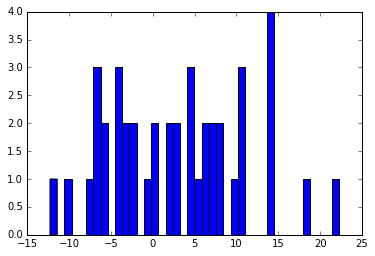

In [5]:
computeAndShowReturnRateInfo(1970, 5)

### 7 year evolution

The return rate from 1970 to 1977 was  -4.16 percent       (1000.00$ to 742.67$)
The return rate from 1971 to 1978 was  -6.72 percent       (1000.00$ to 614.73$)
The return rate from 1972 to 1979 was  -7.47 percent       (1000.00$ to 580.84$)
The return rate from 1973 to 1980 was  -9.10 percent       (1000.00$ to 512.87$)
The return rate from 1974 to 1981 was  -4.19 percent       (1000.00$ to 741.23$)
The return rate from 1975 to 1982 was  -1.60 percent       (1000.00$ to 893.16$)
The return rate from 1976 to 1983 was  -2.35 percent       (1000.00$ to 846.95$)
The return rate from 1977 to 1984 was  -1.18 percent       (1000.00$ to 920.31$)
The return rate from 1978 to 1985 was   1.72 percent       (1000.00$ to 1126.41$)
The return rate from 1979 to 1986 was   3.83 percent       (1000.00$ to 1301.23$)
The return rate from 1980 to 1987 was   7.59 percent       (1000.00$ to 1668.68$)
The return rate from 1981 to 1988 was   5.10 percent       (1000.00$ to 1416.25$)
The return rate from 198

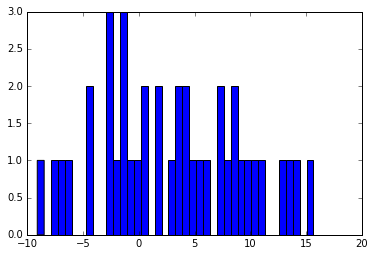

In [6]:
computeAndShowReturnRateInfo(1970, 7)

### 10 year evolution

The return rate from 1970 to 1980 was  -5.03 percent       (1000.00$ to 596.63$)
The return rate from 1971 to 1981 was  -4.20 percent       (1000.00$ to 650.81$)
The return rate from 1972 to 1982 was  -6.79 percent       (1000.00$ to 494.91$)
The return rate from 1973 to 1983 was  -6.14 percent       (1000.00$ to 530.87$)
The return rate from 1974 to 1984 was  -2.31 percent       (1000.00$ to 791.76$)
The return rate from 1975 to 1985 was   1.56 percent       (1000.00$ to 1167.88$)
The return rate from 1976 to 1986 was   0.87 percent       (1000.00$ to 1090.43$)
The return rate from 1977 to 1987 was   2.97 percent       (1000.00$ to 1340.54$)
The return rate from 1978 to 1988 was   4.13 percent       (1000.00$ to 1499.38$)
The return rate from 1979 to 1989 was   4.91 percent       (1000.00$ to 1614.33$)
The return rate from 1980 to 1990 was   6.47 percent       (1000.00$ to 1872.06$)
The return rate from 1981 to 1991 was   4.69 percent       (1000.00$ to 1581.82$)
The return rate from 

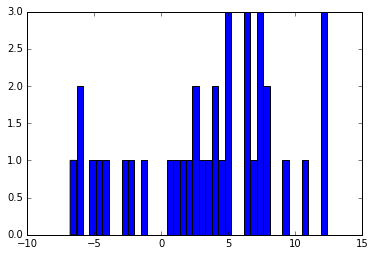

In [7]:
computeAndShowReturnRateInfo(1970, 10)

### 20 year evolution

The return rate from 1970 to 1990 was   0.55 percent       (1000.00$ to 1116.92$)
The return rate from 1971 to 1991 was   0.15 percent       (1000.00$ to 1029.46$)
The return rate from 1972 to 1992 was   0.91 percent       (1000.00$ to 1198.73$)
The return rate from 1973 to 1993 was   0.47 percent       (1000.00$ to 1098.13$)
The return rate from 1974 to 1994 was   2.28 percent       (1000.00$ to 1568.62$)
The return rate from 1975 to 1995 was   4.07 percent       (1000.00$ to 2222.62$)
The return rate from 1976 to 1996 was   4.22 percent       (1000.00$ to 2284.25$)
The return rate from 1977 to 1997 was   5.12 percent       (1000.00$ to 2714.19$)
The return rate from 1978 to 1998 was   7.35 percent       (1000.00$ to 4128.39$)
The return rate from 1979 to 1999 was   8.60 percent       (1000.00$ to 5206.28$)
The return rate from 1980 to 2000 was   9.30 percent       (1000.00$ to 5924.78$)
The return rate from 1981 to 2001 was   8.37 percent       (1000.00$ to 4989.58$)
The return rate 

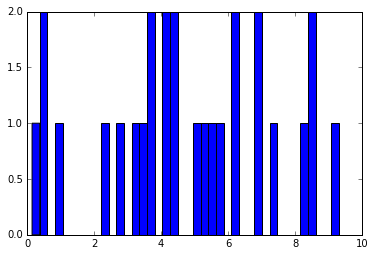

In [8]:
computeAndShowReturnRateInfo(1970, 20)

### 30 year evolution

The return rate from 1970 to 2000 was   4.30 percent       (1000.00$ to 3534.88$)
The return rate from 1971 to 2001 was   4.00 percent       (1000.00$ to 3247.26$)
The return rate from 1972 to 2002 was   3.19 percent       (1000.00$ to 2561.56$)
The return rate from 1973 to 2003 was   1.93 percent       (1000.00$ to 1773.90$)
The return rate from 1974 to 2004 was   3.69 percent       (1000.00$ to 2964.97$)
The return rate from 1975 to 2005 was   5.10 percent       (1000.00$ to 4448.25$)
The return rate from 1976 to 2006 was   4.46 percent       (1000.00$ to 3701.54$)
The return rate from 1977 to 2007 was   4.70 percent       (1000.00$ to 3965.24$)
The return rate from 1978 to 2008 was   5.16 percent       (1000.00$ to 4523.52$)
The return rate from 1979 to 2009 was   3.50 percent       (1000.00$ to 2808.11$)
The return rate from 1980 to 2010 was   4.40 percent       (1000.00$ to 3637.67$)
The return rate from 1981 to 2011 was   4.56 percent       (1000.00$ to 3809.76$)
The return rate 

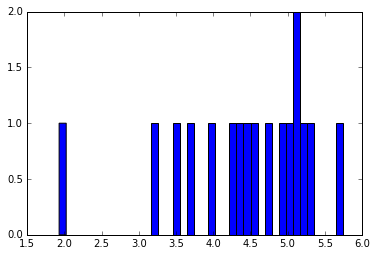

In [9]:
computeAndShowReturnRateInfo(1970, 30)

In [10]:
print(1000 * 1.0461**20)
print(1000 * 1.003**20)
print(1000 * 1.0902**20)

2462.9979020499113
1061.741176240896
5625.013302411652


## Results

We can see that over a long enough time period, we get a positive return rate, independently of the year we bought in. If we buy 1000\$ worth of stocks, on average we'd get 2463\$ at the end of 20 years.

If we bought during the worst year, we'd have 1062\$ after 20 years, and if we bought at the best possible time, we'd have 5625\$ after 20 years.

# We can do a lot better!

The previous analysis has 2 main flaws:

(1) **It assumes people invest their money at the same time, instead of gradually as they earn some through their salary**

Since nobody makes all their money at once, we need to take this into account. There are countless possibilites, as salaries and raises will be different for everyone. For now, I'll forget about this aspect.

(2) **It assumes that dividends (as a shareholder, you have right to some of the companies' earnings: the dividends) are not re-invested**

If you buy 1000\$ of stocks in 1990 and receive 25\$ as dividends, you can re-invest these dividends to buy more stocks. Although it seems small, by re-investing each year the dividends, the return rate increases a lot!

In [11]:
def getDividends(stockData, currentDate, money):
    stockYield = stockData[currentDate]["Real Dividend"] / stockData[currentDate]["Real Price"]
    return stockYield * money

def investWithDividends(stockData, beginningYear, money, numYears):
    for nextYear in allYearsSince(beginningYear + 1, beginningYear + numYears + 1):
        currentDate = (nextYear - 1, 1)
        nextDate = (nextYear, 1)
        dividends = getDividends(stockData, currentDate, money)
        
        currentValue, futureValue = getPrice(stockData, currentDate), getPrice(stockData, nextDate)
        evolution = futureValue / currentValue
    
        money = evolution * money + dividends
       
    return money

print("If we had invested 1000$ in 1970, we'd have %.2f$ in 1990." % investWithDividends(stocksData, 1970, 1000, 20))

If we had invested 1000$ in 1970, we'd have 2333.58$ in 1990.


In [12]:
def getPriceEvolutionWithDividends(beginningYear, timeLapse):
    prices = []
    for year in allYearsSince(beginningYear, maxYear=LAST_YEAR - timeLapse):
        startPrice, endPrice = 1000, investWithDividends(stocksData, year, 1000, timeLapse)
        prices.append((startPrice, endPrice))
    return prices

def computeAndShowReturnRateInfoWithDividends(beginningYear, timeLapse):
    prices = getPriceEvolutionWithDividends(beginningYear, timeLapse)
    returnRates = getReturnRates(prices, timeLapse)
    showPriceEvolutionStats(prices, returnRates, beginningYear, timeLapse)

### 5 year evolution

The return rate from 1970 to 1975 was  -1.94 percent       (1000.00$ to 906.62$)
The return rate from 1971 to 1976 was  -1.21 percent       (1000.00$ to 940.76$)
The return rate from 1972 to 1977 was  -6.17 percent       (1000.00$ to 727.46$)
The return rate from 1973 to 1978 was  -7.39 percent       (1000.00$ to 681.13$)
The return rate from 1974 to 1979 was  -1.86 percent       (1000.00$ to 910.59$)
The return rate from 1975 to 1980 was   7.57 percent       (1000.00$ to 1440.11$)
The return rate from 1976 to 1981 was  -0.97 percent       (1000.00$ to 952.44$)
The return rate from 1977 to 1982 was   2.30 percent       (1000.00$ to 1120.45$)
The return rate from 1978 to 1983 was   8.68 percent       (1000.00$ to 1515.91$)
The return rate from 1979 to 1984 was   8.17 percent       (1000.00$ to 1481.15$)
The return rate from 1980 to 1985 was  11.80 percent       (1000.00$ to 1746.85$)
The return rate from 1981 to 1986 was  14.93 percent       (1000.00$ to 2005.48$)
The return rate from 1

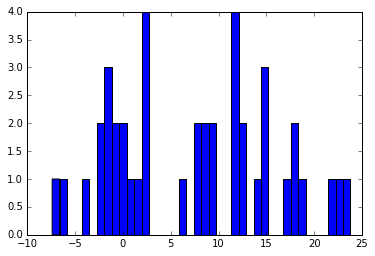

In [13]:
computeAndShowReturnRateInfoWithDividends(1970, 5)

### 10 year evolution

The return rate from 1970 to 1980 was   0.04 percent       (1000.00$ to 1003.72$)
The return rate from 1971 to 1981 was  -1.63 percent       (1000.00$ to 848.06$)
The return rate from 1972 to 1982 was  -0.46 percent       (1000.00$ to 955.24$)
The return rate from 1973 to 1983 was  -0.29 percent       (1000.00$ to 971.14$)
The return rate from 1974 to 1984 was   2.76 percent       (1000.00$ to 1312.38$)
The return rate from 1975 to 1985 was   8.39 percent       (1000.00$ to 2238.35$)
The return rate from 1976 to 1986 was   8.30 percent       (1000.00$ to 2220.26$)
The return rate from 1977 to 1987 was   7.06 percent       (1000.00$ to 1978.73$)
The return rate from 1978 to 1988 was  10.05 percent       (1000.00$ to 2606.25$)
The return rate from 1979 to 1989 was  11.08 percent       (1000.00$ to 2859.85$)
The return rate from 1980 to 1990 was  10.08 percent       (1000.00$ to 2612.96$)
The return rate from 1981 to 1991 was  11.55 percent       (1000.00$ to 2983.17$)
The return rate fro

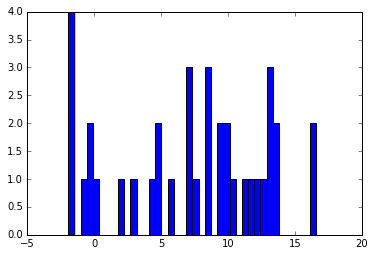

In [14]:
computeAndShowReturnRateInfoWithDividends(1970, 10)

### 20 year evolution

The return rate from 1970 to 1990 was   4.33 percent       (1000.00$ to 2333.58$)
The return rate from 1971 to 1991 was   5.54 percent       (1000.00$ to 2940.71$)
The return rate from 1972 to 1992 was   5.24 percent       (1000.00$ to 2778.06$)
The return rate from 1973 to 1993 was   5.02 percent       (1000.00$ to 2663.03$)
The return rate from 1974 to 1994 was   6.32 percent       (1000.00$ to 3407.03$)
The return rate from 1975 to 1995 was   9.64 percent       (1000.00$ to 6299.19$)
The return rate from 1976 to 1996 was   9.35 percent       (1000.00$ to 5970.15$)
The return rate from 1977 to 1997 was  10.30 percent       (1000.00$ to 7104.75$)
The return rate from 1978 to 1998 was  12.61 percent       (1000.00$ to 10750.34$)
The return rate from 1979 to 1999 was  12.92 percent       (1000.00$ to 11366.97$)
The return rate from 1980 to 2000 was  12.27 percent       (1000.00$ to 10119.57$)
The return rate from 1981 to 2001 was  10.75 percent       (1000.00$ to 7708.93$)
The return ra

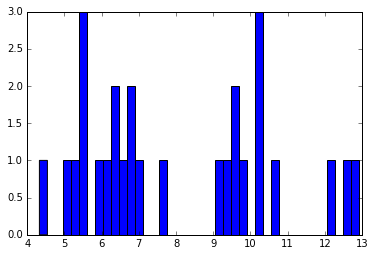

In [15]:
computeAndShowReturnRateInfoWithDividends(1970, 20)

### 30 year evolution

The return rate from 1970 to 2000 was   7.61 percent       (1000.00$ to 9037.59$)
The return rate from 1971 to 2001 was   6.99 percent       (1000.00$ to 7599.21$)
The return rate from 1972 to 2002 was   5.76 percent       (1000.00$ to 5368.79$)
The return rate from 1973 to 2003 was   6.12 percent       (1000.00$ to 5949.25$)
The return rate from 1974 to 2004 was   7.16 percent       (1000.00$ to 7960.62$)
The return rate from 1975 to 2005 was   8.59 percent       (1000.00$ to 11846.91$)
The return rate from 1976 to 2006 was   8.01 percent       (1000.00$ to 10096.58$)
The return rate from 1977 to 2007 was   7.61 percent       (1000.00$ to 9040.08$)
The return rate from 1978 to 2008 was   6.63 percent       (1000.00$ to 6863.83$)
The return rate from 1979 to 2009 was   7.34 percent       (1000.00$ to 8374.48$)
The return rate from 1980 to 2010 was   7.72 percent       (1000.00$ to 9314.16$)
The return rate from 1981 to 2011 was   7.31 percent       (1000.00$ to 8313.13$)
The return rat

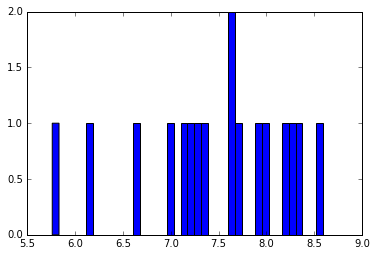

In [16]:
computeAndShowReturnRateInfoWithDividends(1970, 30)

## Analysis

We can see that over a long enough time period, we never lose money. If we invest during 20 years, the minimum we could make was a 4.3% return rate, which is really good. 

If we invest even longer (30 years), the return rate stabilises at about 7.5% and can vary between 5.75% and 8.6%. On average, our 1000\$ would transform into 8755\$, inflation-adjusted! That's an amazing return rate. You could increase your money eight-fold over 30 years by simply re-investing it.

Let's look at the extreme situations:

- If you invested at the worst possible time (1972) and had to sell everything in 2002 (just after the DotCom bubble crashed), your return rate would have been 5.75%. Thus, your 1000\$ would have transformed into 5351\$. Of course, in reality, you would have simply waited a couple of year for the stock market to improve again, so this situation is a absolute worst-case scenario.

- If you invested at the best possible time (1975) and had to sell everything in 2005 (the stock market had partially recovered from the DotCom bubble crash), your return rate would be 8.6%. Thus, your your 1000\$ would have transformed into 11882\$. 

As we can see, over a long enough time period, the power of compounding is enormous. A 5.75% return rate, over 0 yeas, would more than improve 5-fold your money. A 3% difference, from 5.75% to 8.6% return rate, would more than double the result: you'd more than 11-fold improve your money.

In [17]:
print(1000 * 1.075 ** 30)
print(1000 * 1.0575 ** 30)
print(1000 * 1.086 ** 30)

8754.955188968896
5350.708372131398
11882.1425304206


## Constant investing over time

Most people don't invest all their money at once. Instead, they put part of their salary in an investment account each month. 


In this simulation, we're considering that we're always putting the same amount every year (in inflation-adjusted dollars) and putting it once a year. The practice of always placing the same amount of money is called **dollar-cost averaging**. The advantage is that you'll buy many shares when the prices are low, and less when prices are high.

We also introduce the fees for the index fund.

In [24]:
FEES = 0.0017

def investYearlyWithDividends(stockData, beginningYear, money, addedMoneyPerYear, numYears):
    for nextYear in allYearsSince(beginningYear + 1, beginningYear + numYears + 1):
        currentDate = (nextYear - 1, 1)
        nextDate = (nextYear, 1)
        dividends = getDividends(stockData, currentDate, money)
        
        currentValue, futureValue = getPrice(stockData, currentDate), getPrice(stockData, nextDate)
        evolution = futureValue / currentValue
    
        money = money * evolution * (1 - FEES) + dividends + addedMoneyPerYear
       
    return money

print("If we had invested 1000$ in 1970 and investing an extra 1000$ yearly (total: 21000$), we'd have %.2f$ in 1990." % investYearlyWithDividends(stocksData, 1970, 1000, 1000, 20))

If we had invested 1000$ in 1970 and investing an extra 1000$ yearly (total: 21000$), we'd have 44368.54$ in 1990.


In [25]:
def getPriceEvolutionWithDividendsYearly(beginningYear, addedMoneyPerYear, timeLapse):
    prices = []
    for year in allYearsSince(beginningYear, maxYear=LAST_YEAR - timeLapse):
        beginningMoney = addedMoneyPerYear
        startPrice = beginningMoney + addedMoneyPerYear * timeLapse
        endPrice = investYearlyWithDividends(stocksData, year, beginningMoney, addedMoneyPerYear, timeLapse)
        prices.append((startPrice, endPrice))
    return prices

def bisection(f, minVal, maxVal, goal):
    EPSILON = 10 ** -8
    while abs(maxVal - minVal) > EPSILON:
        mid = (maxVal + minVal) / 2
        val = f(mid)
        if val > goal:
            maxVal = mid
        elif val < goal:
            minVal = mid
        else:
            return mid
    return (maxVal + minVal) / 2
            

def computeReturnRate(timeLapse, addedMoneyPerYear, endPrice):
    totalMoney = addedMoneyPerYear * (timeLapse + 1)
    # addedMoneyPerYear * (1 + S + S² + ... + S^timelapse) = endPrice
    # reduces to
    # (S^(timeLapse + 1) - 1)/(S - 1) = endPrice / addedMoneyPerYear
    # which can be solve through bisection
    if totalMoney < endPrice:
        totalReturnRate = bisection(lambda x: (x ** (timeLapse + 1.0) - 1.0) / (x - 1.0), 1.0, 2.0, endPrice / addedMoneyPerYear)
    else:
        totalReturnRate = bisection(lambda x: (x ** (timeLapse + 1.0) - 1.0) / (x - 1.0), 0.0, 1.0, endPrice / addedMoneyPerYear)
    return (totalReturnRate - 1) * 100

def getReturnRatesWithYearlyInvestments(prices, timeLapse, addedMoneyPerYear):
    return [computeReturnRate(timeLapse, addedMoneyPerYear, endPrice) for (startPrice, endPrice) in prices]

def computeAndShowReturnRateInfoWithDividendsYearly(beginningYear, timeLapse):
    beginningMoney = 1000 / (timeLapse + 1)
    addedMoneyPerYear = (1000 - beginningMoney) / timeLapse
    
    prices = getPriceEvolutionWithDividendsYearly(beginningYear, addedMoneyPerYear, timeLapse)
    returnRates = getReturnRatesWithYearlyInvestments(prices, timeLapse, addedMoneyPerYear)
    showPriceEvolutionStats(prices, returnRates, beginningYear, timeLapse)

### 5 year evolution

The return rate from 1970 to 1975 was   3.25 percent       (1000.00$ to 1084.95$)
The return rate from 1971 to 1976 was   5.68 percent       (1000.00$ to 1153.27$)
The return rate from 1972 to 1977 was   0.67 percent       (1000.00$ to 1016.87$)
The return rate from 1973 to 1978 was   4.47 percent       (1000.00$ to 1118.63$)
The return rate from 1974 to 1979 was   7.23 percent       (1000.00$ to 1199.07$)
The return rate from 1975 to 1980 was  11.73 percent       (1000.00$ to 1343.45$)
The return rate from 1976 to 1981 was   4.39 percent       (1000.00$ to 1116.44$)
The return rate from 1977 to 1982 was  12.13 percent       (1000.00$ to 1356.99$)
The return rate from 1978 to 1983 was  16.56 percent       (1000.00$ to 1517.52$)
The return rate from 1979 to 1984 was  15.60 percent       (1000.00$ to 1481.05$)
The return rate from 1980 to 1985 was  20.19 percent       (1000.00$ to 1663.01$)
The return rate from 1981 to 1986 was  26.28 percent       (1000.00$ to 1937.48$)
The return rate 

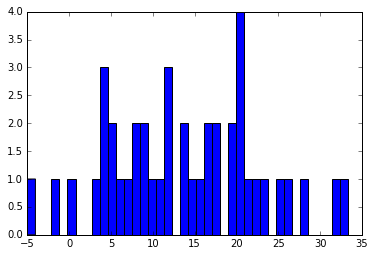

In [26]:
computeAndShowReturnRateInfoWithDividendsYearly(1970, 5)

### 10 year evolution

The return rate from 1970 to 1980 was   2.81 percent       (1000.00$ to 1153.19$)
The return rate from 1971 to 1981 was   0.09 percent       (1000.00$ to 1004.43$)
The return rate from 1972 to 1982 was   4.27 percent       (1000.00$ to 1243.35$)
The return rate from 1973 to 1983 was   6.88 percent       (1000.00$ to 1425.62$)
The return rate from 1974 to 1984 was   7.58 percent       (1000.00$ to 1479.54$)
The return rate from 1975 to 1985 was  10.59 percent       (1000.00$ to 1739.43$)
The return rate from 1976 to 1986 was  13.82 percent       (1000.00$ to 2074.08$)
The return rate from 1977 to 1987 was  11.77 percent       (1000.00$ to 1854.32$)
The return rate from 1978 to 1988 was  12.91 percent       (1000.00$ to 1973.25$)
The return rate from 1979 to 1989 was  14.20 percent       (1000.00$ to 2118.18$)
The return rate from 1980 to 1990 was  11.60 percent       (1000.00$ to 1837.18$)
The return rate from 1981 to 1991 was  14.43 percent       (1000.00$ to 2145.46$)
The return rate 

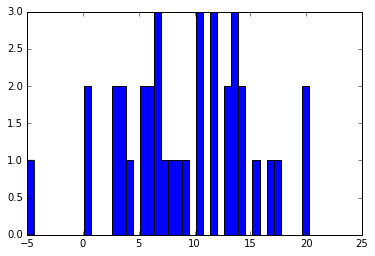

In [27]:
computeAndShowReturnRateInfoWithDividendsYearly(1970, 10)

### 20 year evolution

The return rate from 1970 to 1990 was   6.90 percent       (1000.00$ to 2112.79$)
The return rate from 1971 to 1991 was   8.73 percent       (1000.00$ to 2616.55$)
The return rate from 1972 to 1992 was   8.77 percent       (1000.00$ to 2629.88$)
The return rate from 1973 to 1993 was   9.19 percent       (1000.00$ to 2766.64$)
The return rate from 1974 to 1994 was   8.81 percent       (1000.00$ to 2643.78$)
The return rate from 1975 to 1995 was  10.68 percent       (1000.00$ to 3309.85$)
The return rate from 1976 to 1996 was  11.73 percent       (1000.00$ to 3764.65$)
The return rate from 1977 to 1997 was  13.05 percent       (1000.00$ to 4428.39$)
The return rate from 1978 to 1998 was  14.53 percent       (1000.00$ to 5334.26$)
The return rate from 1979 to 1999 was  14.75 percent       (1000.00$ to 5479.31$)
The return rate from 1980 to 2000 was  13.31 percent       (1000.00$ to 4574.71$)
The return rate from 1981 to 2001 was  11.28 percent       (1000.00$ to 3559.87$)
The return rate 

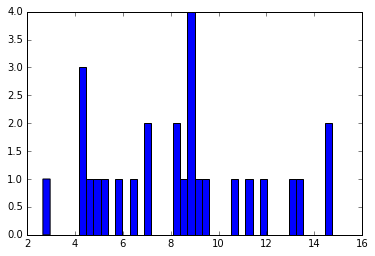

In [28]:
computeAndShowReturnRateInfoWithDividendsYearly(1970, 20)

### 30 year evolution

The return rate from 1970 to 2000 was  10.17 percent       (1000.00$ to 6067.37$)
The return rate from 1971 to 2001 was   9.16 percent       (1000.00$ to 4981.36$)
The return rate from 1972 to 2002 was   7.66 percent       (1000.00$ to 3727.91$)
The return rate from 1973 to 2003 was   8.65 percent       (1000.00$ to 4508.52$)
The return rate from 1974 to 2004 was   8.61 percent       (1000.00$ to 4474.81$)
The return rate from 1975 to 2005 was   8.64 percent       (1000.00$ to 4499.12$)
The return rate from 1976 to 2006 was   8.76 percent       (1000.00$ to 4609.82$)
The return rate from 1977 to 2007 was   8.15 percent       (1000.00$ to 4093.62$)
The return rate from 1978 to 2008 was   5.51 percent       (1000.00$ to 2500.80$)
The return rate from 1979 to 2009 was   6.50 percent       (1000.00$ to 2998.56$)
The return rate from 1980 to 2010 was   6.78 percent       (1000.00$ to 3161.06$)
The return rate from 1981 to 2011 was   6.34 percent       (1000.00$ to 2911.98$)
The return rate 

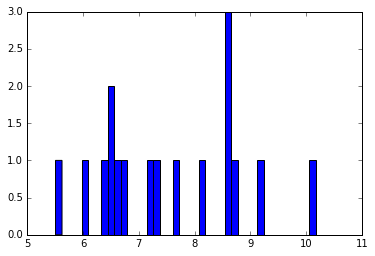

In [29]:
computeAndShowReturnRateInfoWithDividendsYearly(1970, 30)

## Analysis

We can see that we aren't required to put our money at once. If we put our money year by year, we still get amazing return rates. In fact, over the long run it makes pratically no difference on the average return rate.

Given that we introduced the fees in this section, yet we still keep the same average, it means that dollar-cost averaging is a good solution, increasing our real return on our money.

On the other hand, it does seem to raise variability, which is a result that surprises me.